In [4]:
%matplotlib inline
import lsst.daf.persistence as dafPersist
import lsst.afw.table as afwTable
import lsst.afw.geom as afwGeom
import lsst.afw.coord as afwCoord
import lsst.afw.image as afwImage
import numpy as np
import matplotlib
import matplotlib.pylab as plt
from astropy.table import Table, vstack

tract = 0
visit = 1230
filter = 'HSC-I'

#fluxT = 'base_CircularApertureFlux_6_0'
#fluxT = 'ext_photometryKron_KronFlux'
fluxT = 'base_PsfFlux'

butler = dafPersist.Butler("/sps/lsst/dev/lsstprod/hsc/SSP_UDEEP_COSMOS/output/rerun/rerun")

for ccd in range(104):
    if ccd == 9:
        continue

    dataid = {'visit':visit, 'filter':filter, 'ccd':ccd, 'tract':tract}

    mdRef = butler.get("calexp_md", dataid, immediate=True)
    calibOld = afwImage.Calib(mdRef)
    photoCalib = butler.get('photoCalib', dataid, immediate=True)
    calibNew = afwImage.Calib(photoCalib.getInstFluxMag0())

    src = butler.get('src', dataid, immediate=True).asAstropy()

    cut = (src[fluxT + '_flag'] == 0) & (src[fluxT + '_flux'] > 0.)
    cut &= (src[fluxT + '_flux']/src[fluxT + '_fluxSigma'] > 10.)
    cut &= (src['base_ClassificationExtendedness_value'] < 0.5)
    cut &= (src['parent'] == 0) & (src['deblend_nChild'] == 0)

    clean = src[cut]

    magOld = calibOld.getMagnitude(clean[fluxT + '_flux'])
    magNew = calibNew.getMagnitude(clean[fluxT + '_flux'])
    
    flux = []
    fluxErr = []
    for s in clean:
        val = photoCalib.instFluxToMaggies(s['base_PsfFlux_flux'], s['base_PsfFlux_fluxSigma'],
                                             afwGeom.Point2D(s['base_SdssCentroid_x'], s['base_SdssCentroid_y']))
        flux.append(val.value)
        fluxErr.append(val.err)

    clean['magOld'] = magOld
    clean['magNew'] = magNew
    clean['ccd'] = ccd
    clean['magCal'] = -2.5*np.log10(flux)

    if ccd == 0:
        catalog = clean
    else:
        catalog = vstack([catalog, clean])

In [7]:
cal = photoCalib.computeScaledCalibration()
cal.evaluate

In [5]:
from lsst.afw.image import abMagFromFlux
from lsst.meas.algorithms import LoadIndexedReferenceObjectsTask

refConfig = LoadIndexedReferenceObjectsTask.ConfigClass()
refConfig.ref_dataset_name = 'pan-starrs'

refTask = LoadIndexedReferenceObjectsTask(butler, config=refConfig)
filt = 'i'
flux = filt + '_flux'

# Find the approximate celestial coordinates corresponding to the center of the focal plane (ccd=49)
dataid = {'visit':visit, 'filter':filter, 'ccd':49}
cal = butler.get('calexp', dataId=dataid)
wcs = cal.getWcs()
center = wcs.pixelToSky(0, 0)
radius = 2.0
skyCircle = refTask.loadSkyCircle(center, afwGeom.Angle(radius, afwGeom.degrees), filt)

refCat = skyCircle.refCat.copy(deep=True).asAstropy()

# clean up reference catalog
clean = (refCat['r_fluxSigma'] > 0) 
refCat = refCat[clean]
clean = (refCat['i_flux']/refCat['i_fluxSigma'] > 10) & (abMagFromFlux(refCat['i_flux']) < 23)
refCat = refCat[clean]
len(refCat)

/sps/lsst/software/lsst_distrib/w_2017_49/python/miniconda3-4.3.21/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide
/sps/lsst/software/lsst_distrib/w_2017_49/python/miniconda3-4.3.21/lib/python3.6/site-packages/astropy/table/column.py:928: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, oper)(other)
/sps/lsst/software/lsst_distrib/w_2017_49/python/miniconda3-4.3.21/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in less


283502

In [6]:
from astropy.coordinates import SkyCoord
from astropy import units as u

cData = SkyCoord(ra = catalog['coord_ra'], dec = catalog['coord_dec'])
cRef = SkyCoord(ra = refCat['coord_ra'], dec = refCat['coord_dec'])

idxRef, d2dRef, d3dRef = cData.match_to_catalog_sky(cRef)
print(len(cData), len(cRef), len(idxRef))

16068 283502 16068


In [7]:
catalog['dist'] = d2dRef.arcsec 
catalog['magRef'] = abMagFromFlux(refCat[idxRef]['i_flux'])

cut2 = (catalog['magOld'] < 23)
newCat = catalog[cut2]

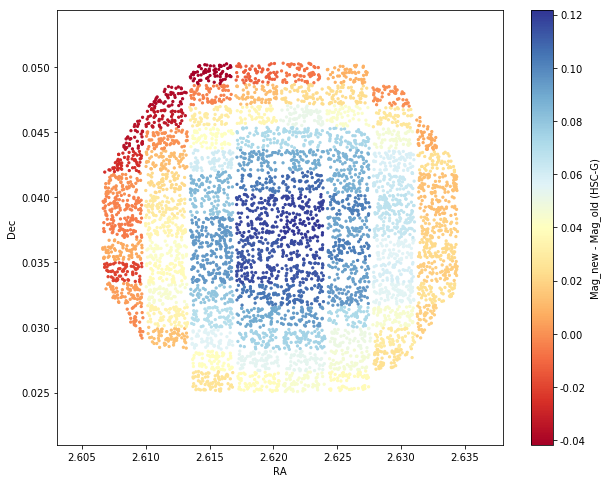

In [8]:
cc = (newCat['magNew'] - newCat['magOld'] < 1) & (newCat['magNew'] - newCat['magOld'] > -1)

fig, (ax0) = plt.subplots(ncols=1, figsize=(10, 8))
sc = ax0.scatter(newCat[cc]['coord_ra'], newCat[cc]['coord_dec'], c = newCat[cc]['magNew'] - newCat[cc]['magOld'], s=5, cmap=plt.cm.RdYlBu)
cb = fig.colorbar(sc, format='%.2f')
cb.set_label('Mag_new - Mag_old (HSC-G)')
ax0.set_xlabel('RA')
ax0.set_ylabel('Dec')
fig.savefig('jointcal_color_ra_dec_i_simple.png')

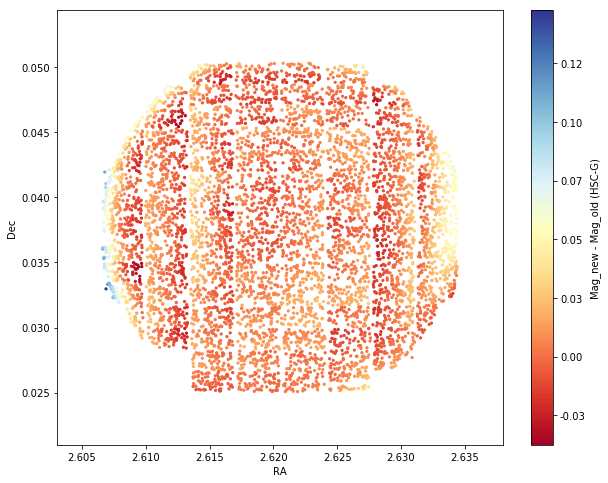

In [13]:
#cc = (newCat['magNew'] - newCat['magOld'] < 1) & (newCat['magNew'] - newCat['magOld'] > -1)

fig, (ax0) = plt.subplots(ncols=1, figsize=(10, 8))
sc = ax0.scatter(newCat[cc]['coord_ra'], newCat[cc]['coord_dec'], c = newCat[cc]['magCal'] - newCat[cc]['magOld'], s=5, cmap=plt.cm.RdYlBu)
cb = fig.colorbar(sc, format='%.2f')
cb.set_label('Mag_new - Mag_old (HSC-G)')
ax0.set_xlabel('RA')
ax0.set_ylabel('Dec')
fig.savefig('jointcal_color_ra_dec_i_simple_cal.png')